# Challenge AI giugno: Pokemon - Riccardo Moglioni

## Training

In [1]:
!pip install pandas
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Elaborazione dei dati

In [2]:
# Lettura dei file csv
train_path = "train.csv"
train = pd.read_csv(train_path)

test_path = "test.csv"
test = pd.read_csv(test_path)

In [3]:
# Visualizzo i dati
# Da una prima osservazione, considerando l'assunzione fatta nel testo della prova:
# "Il pokemon nella prima colonna attacca per primo" (con una configurazione delle 
# colonne identica a questa), sembra che il primo pokemon abbia più probabilità 
# di vittoria. Occorre realizzare una feature che tenga conto di questo.
# I valori nelle colonne seppur numerici rappresentano delle etichette, li sostituisco 
# con 0/1 ad indicare 0=primo pokemon e 1=secondo pokemon. 
# Al termine posso poi riconvertire
train.head()

,First_pokemon,Second_pokemon,Winner
0,124,221,124
1,323,1,1
2,58,459,58
3,180,491,491
4,799,559,799


In [4]:
# Controllo di eventuali valori mancanti

# Calcolo dei valori missing in funzione delle colonne
train_missing_values_count = train.isnull().sum()
print(train_missing_values_count)
test_missing_values_count = test.isnull().sum()
print(test_missing_values_count)

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64
First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64


In [5]:
# Non ci sono valori nulli e tutti i valori sono numerici 
# e conformi al tipo di dato che mi aspetto
print(train.describe())
print(test.describe())

       First_pokemon  Second_pokemon        Winner
count   32000.000000    32000.000000  32000.000000
mean      400.581500      402.452063    408.302250
std       229.831285      230.277071    231.131808
min         1.000000        1.000000      1.000000
25%       202.000000      206.000000    205.000000
50%       400.000000      401.000000    421.000000
75%       599.000000      602.000000    606.000000
max       800.000000      800.000000    800.000000
       First_pokemon  Second_pokemon       Winner
count    8000.000000      8000.00000  8000.000000
mean      403.340750       404.74475   411.908375
std       230.489596       229.81238   231.711407
min         1.000000         1.00000     1.000000
25%       206.750000       207.00000   212.000000
50%       403.000000       405.00000   426.000000
75%       600.000000       606.00000   608.000000
max       800.000000       800.00000   800.000000


(-1.0, 2.0)

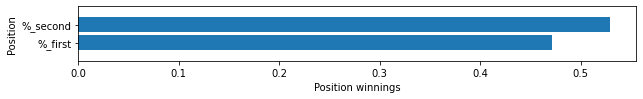

In [6]:
# Visualizziamo la percentuale di vittorie in funzione della posizione del pokemon
def fWinnerPer(df1, df2):
    fwin = 0
    count = 0
    for i in range(len(df1)):
        if df1.loc[i,'Winner'] == df1.loc[i,'First_pokemon']:
            fwin = fwin+1
        count = count+1
    for i in range(len(df2)):
        if df2.loc[i,'Winner'] == df2.loc[i,'First_pokemon']:
            fwin = fwin+1
        count = count+1
    return fwin/count

# Calcolo i valori per le due posizioni
first = fWinnerPer(train, test)
second = 1-first
result = [first, second]

# Stampo il grafo
plt.figure(figsize=(10,1))
plt.barh(np.arange(2), result, align='center')
plt.yticks(np.arange(2), ['%_first', '%_second'])
plt.xlabel("Position winnings")
plt.ylabel("Position")
plt.ylim(-1, 2)

In [7]:
# Fornite tutti valori 1 (vittoria del secondo) da circa il 53% di risultati corretti
result

[0.4712, 0.5287999999999999]

In [8]:
# A quanto pare l'assunzione fatta in precedenza è errata. La posizione, quindi chi attacca per primo, 
# non è rilevante in termini di numero di vittorie. Forse i pokemon in prima posizione sono svantaggiati 
# in termini di forza, quindi l'attaccare per primi gli permette di colmare la differenza? Occorre 
# verificare quanto i primi siano svantaggiati rispetto i secondi. Occorre acquisire i valori dei 
# singoli pokemon

In [9]:
# Creazione della nuova colonna winner

# creo due colonne original nel caso voglia riconvertire i valori al termine delle operazioni
# per fornire il risultato
original_train_y = train.Winner
original_test_y = test.Winner

#Funzione che crea la colonna "num-winner" con valori 0 quando vince il primo pokemon, 1 altrimenti
def winner_conversion(df):
    for i in range(len(df)):
        if df.loc[i,'Winner'] == df.loc[i,'First_pokemon']:
            df.loc[i,'num_winner']=int(0)
        else:
            df.loc[i,'num_winner']=int(1)

# Applico la funzione a train e test
winner_conversion(train)
winner_conversion(test)

train.head()

,First_pokemon,Second_pokemon,Winner,num_winner
0,124,221,124,0.0
1,323,1,1,1.0
2,58,459,58,0.0
3,180,491,491,1.0
4,799,559,799,0.0


In [10]:
# Rimozione della vecchia colonna Winner
X_train = train.drop(['Winner'], axis=1)

X_test = test.drop(['Winner'], axis=1)

### Inserimento dei valori relativi ai pokemon (dal file pokemon.csv)

In [11]:
# Lettura del file
pokemon_path = "pokemon.csv"
pokemon_raw = pd.read_csv(pokemon_path)
pokemon_raw.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [12]:
# Controllo di eventuali valori nulli nella tabella pokemon

# Calcolo dei valori missing in funzione delle colonne
pokemon_missing_values_count = pokemon_raw.isnull().sum()
print(pokemon_missing_values_count)

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


In [13]:
# Risultano alcuni valori nulli:
# - manca un nome, ma per quella che sarà l'elaborazione dei dati i nomi saranno 
#                  omessi quindi il problema è trascurabile
# - mancano dei Type 2, rappresentando la seconda tipologia del pokemon non tutti 
#                       i pokemon hanno tale caratteristica (credo) per questo 
#                       occorre gestire questa mancanza

In [14]:
print(pokemon_raw['Type 1'].describe())
print(pokemon_raw['Type 2'].describe())

count       800
unique       18
top       Water
freq        112
Name: Type 1, dtype: object
count        414
unique        18
top       Flying
freq          97
Name: Type 2, dtype: object


In [15]:
# Mia ignoranza sui pokemon:
# Dopo una breve ricerca su generazioni di pokemon e pokemon leggendari ho scoperto 
# che le generazioni si riferiscono ai gruppi di pokemon introdotti del tempo, quindi 
# inutile al fine della classificazione, mentre i pokemon leggendari sono tali per 
# potenza maggiore nel combattimento. Quest'ultima caratteristica può essere 
# rappresentata dai valori di attacco, difesa, HP, ... gia presenti.
# Quindi ritengo di poter eliminare anche questa colonna.
# Oltre a questo, il tipo di pokemon definisce le mosse che può usare e quale effetto 
# hanno sui diversi tipi di pokemon. 
# Sono definite 18 tipologie per ogni colonna type. Occorre applicare un encoding 
# per estrarre dei valori numerici da queste due colonne categoriche.
pokemon = pokemon_raw.drop(['Name','Generation','Legendary'], axis=1)
pokemon.head()

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Grass,Poison,45,49,49,65,65,45
1,2,Grass,Poison,60,62,63,80,80,60
2,3,Grass,Poison,80,82,83,100,100,80
3,4,Grass,Poison,80,100,123,122,120,80
4,5,Fire,NaN,39,52,43,60,50,65


In [16]:
# Gestione del Type
# Effettuare una OneHot Encoding porta alla creazione di 36 colonne (18*2) 
# le quali andranno in merge con quelle del pokemon avversario producendo un 
# totale di 72 colonne aggiuntive.
# Essendo il numero di valori di ogni colonna un po troppo elevto per una OneHot 
# e per limitare il numero di colonne effettuo una Label Encoding associando ad 
# ogni valore delle due colonne un numero. In questo modo le colonne restano 2 
# ma introduco un ordinamento nelle tipologie che non è menzionato nei dati 
# (possibile nota negativa nella strategia).

# Inizio sostituendo i valori nulli con una stringa da me generata.
pokemon['Type 2'] = pokemon['Type 2'].fillna('aaa')
pokemon.head()
# La riga 4 (come tutte le altre) ha ora Tipe 2 assegnato

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Grass,Poison,45,49,49,65,65,45
1,2,Grass,Poison,60,62,63,80,80,60
2,3,Grass,Poison,80,82,83,100,100,80
3,4,Grass,Poison,80,100,123,122,120,80
4,5,Fire,aaa,39,52,43,60,50,65


In [17]:
# Effettuo una copia per non modificare i dati originali 
label_pokemon = pokemon.copy()

# Creazione della lista delle colonne di valori categorici
s = (pokemon.dtypes == 'object')
object_cols = list(s[s].index)

# Creazione del Label Encoder e sua applicazione a tutte le colonne categoriche.
label_encoder = LabelEncoder()
for col in object_cols:
    label_pokemon[col] = label_encoder.fit_transform(pokemon[col])
label_pokemon.head()

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,9,13,45,49,49,65,65,45
1,2,9,13,60,62,63,80,80,60
2,3,9,13,80,82,83,100,100,80
3,4,9,13,80,100,123,122,120,80
4,5,6,18,39,52,43,60,50,65


In [18]:
# Effettuo il merge tra le tabelle "combats" (test e train) e pokemon
trainp1 = X_train.merge(label_pokemon, left_on='First_pokemon', right_on='#', validate='many_to_one')
trainp2 = trainp1.merge(label_pokemon, left_on='Second_pokemon', right_on='#', suffixes=("", "_2"), validate='many_to_one')
print(trainp2.head())

testp1 = X_test.merge(label_pokemon, left_on='First_pokemon', right_on='#', validate='many_to_one')
testp2 = testp1.merge(label_pokemon, left_on='Second_pokemon', right_on='#', suffixes=("", "_2"), validate='many_to_one')

   First_pokemon  Second_pokemon  num_winner    #  Type 1  Type 2   HP  \
0            124             221         0.0  124      12      18  105   
1             61             221         0.0   61      17      18   80   
2            515             221         0.0  515      12      18  110   
3            332             221         1.0  332      16      15   60   
4            210             221         1.0  210      17      10   55   

   Attack  Defense  Sp. Atk  ...  Speed  #_2  Type 1_2  Type 2_2  HP_2  \
0      95       80       40  ...     90  221         0        16    75   
1      82       78       95  ...     85  221         0        16    75   
2      85       95       80  ...     50  221         0        16    75   
3      90      140       50  ...     40  221         0        16    75   
4      45       45       25  ...     15  221         0        16    75   

   Attack_2  Defense_2  Sp. Atk_2  Sp. Def_2  Speed_2  
0        90        140         60         60       40 

In [19]:
# Rimozione delle colonne # e #_2
trainp2= trainp2.drop(['#','#_2'], axis=1)
testp2= testp2.drop(['#','#_2'], axis=1)
trainp2.columns

Index(['First_pokemon', 'Second_pokemon', 'num_winner', 'Type 1', 'Type 2',
       'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Type 1_2',
       'Type 2_2', 'HP_2', 'Attack_2', 'Defense_2', 'Sp. Atk_2', 'Sp. Def_2',
       'Speed_2'],
      dtype='object')

In [20]:
# Estraggo le colonne Type e winner per eseguire i calcoli sulle restanti colonne per poi reinserirle
type_col = ['Type 1','Type 2','Type 1_2','Type 2_2','num_winner']
other_col = trainp2.columns.drop(type_col)

train_type = trainp2.drop(other_col, axis=1)
test_type = testp2.drop(other_col, axis=1)

trainp2 = trainp2.drop(type_col, axis=1)
testp2 = testp2.drop(type_col, axis=1)

train_type.head()

,num_winner,Type 1,Type 2,Type 1_2,Type 2_2
0,0.0,12,18,0,16
1,0.0,17,18,0,16
2,0.0,12,18,0,16
3,1.0,16,15,0,16
4,1.0,17,10,0,16


In [21]:
# I valori dei due pokemon vengono rappresentati dalla differenza di questi:
# HP = HP-HP_2
# Attack = Attack-Attack_2
# Defense = Defense-Defense_2
# e cosi anche Sp. Atk, Sp. Def e Speed
# Dato che il pokemon 1 attacca per primo rappresento i valori come "quanto il primo è più/meno forte del secondo"

# definisco con pk_value_col le colonne con attacco, difesa,... dei due pokemon nella tabella seguente
pk_value_col = trainp2.columns.drop(['First_pokemon','Second_pokemon']) # ora non servono più
not_pk_value_col = trainp2.columns.drop(pk_value_col)

pk_value_train = trainp2.drop(not_pk_value_col, axis=1)
not_pk_value_train = trainp2.drop(pk_value_col, axis=1)

pk_value_test = testp2.drop(not_pk_value_col, axis=1)
not_pk_value_test = testp2.drop(pk_value_col, axis=1)

In [22]:
pk_value_train.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2
0,105,95,80,40,80,90,75,90,140,60,60,40
1,80,82,78,95,80,85,75,90,140,60,60,40
2,110,85,95,80,95,50,75,90,140,60,60,40
3,60,90,140,50,50,40,75,90,140,60,60,40
4,55,45,45,25,25,15,75,90,140,60,60,40


In [23]:
# Funzione che calcola la differenza tra tutte le coppie di colonne colonna-colonna_2
def calcola_dif(df):
    l = int(len(df.columns)/2)
    result_col = df.columns[0:l]
#    for i in range(len(df)):
#        for c in result_col:
#            df.loc[i,c] = df.loc[i,c]-df.loc[i,c+'_2']
    for c in result_col:
        df['dif_'+c] = df[c] - df[c+'_2']

In [24]:
# Applico la funzione precente a train e test
calcola_dif(pk_value_train)
calcola_dif(pk_value_test)

In [25]:
pk_value_train.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2,dif_HP,dif_Attack,dif_Defense,dif_Sp. Atk,dif_Sp. Def,dif_Speed
0,105,95,80,40,80,90,75,90,140,60,60,40,30,5,-60,-20,20,50
1,80,82,78,95,80,85,75,90,140,60,60,40,5,-8,-62,35,20,45
2,110,85,95,80,95,50,75,90,140,60,60,40,35,-5,-45,20,35,10
3,60,90,140,50,50,40,75,90,140,60,60,40,-15,0,0,-10,-10,0
4,55,45,45,25,25,15,75,90,140,60,60,40,-20,-45,-95,-35,-35,-25


In [26]:
# Ottenuti questi valori possiamo vedere quanta differenza ci sia tra i pokemon in prima 
# posizione e quelli in seconda, rivedendo il raggionamento fatto all'inizio

# Funzione che calcola per la colonna passata la percentuale di valori positivi rispetto al totale
colonne =[]
def fBestPer(df1, df2, col):
    fbest = 0
    count = 0
    for i in range(len(df1)):
        if df1.loc[i,col] > 0 & (col.startswith('dif')) & (not col.endswith('_2')):
            fbest = fbest+1
        count = count+1
        if col.startswith('dif'):
            colonne.append(col)
    for i in range(len(df2)):
        if df2.loc[i,col] > 0 & (not col.startswith('dif')) & (not col.endswith('_2')):
            fbest = fbest+1
        count = count+1
    return fbest/count

(-1.0, 18.0)

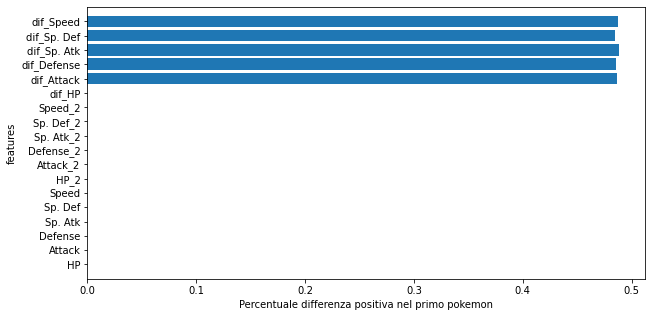

In [27]:
# Calcolo tutte le percentuali per le differenze annullando tutti gli altri valori
first = []
for col in pk_value_test.columns:
    first.append(fBestPer(pk_value_train, pk_value_test, col))
for h in range(0,13):
    first[h]= 0

# Stampo il grafo
plt.figure(figsize=(10,5))
plt.barh(np.arange(18), first, align='center')
plt.yticks(np.arange(18), pk_value_test.columns)
plt.xlabel("Percentuale differenza positiva nel primo pokemon")
plt.ylabel("features")
plt.ylim(-1, 18)

In [28]:
# Considerando il risultato ottenuto ed il precedente si può supporre che la posizione 
# (chi inizia) non da vantaggio al pokemon. Abbiamo verificato che i pokemon in prima 
# posizione hanno un numero leggermente inferiore di vittorie rispetto ai secondi e con 
# il grafo qui sopra possiamo verificare che ciò è dovuto al fatto che i primi hanno 
# delle caratteristiche leggermente inferiori rispetto ai secondi.
# Ritengo quindi trascurabile la considerazione per cui il primo attacca per primo.

In [29]:
# Aggiungo le colonne type e winner precedentemente rimosse
pk_train = pd.concat([pk_value_train, train_type], axis=1)
pk_test = pd.concat([pk_value_test, test_type], axis=1)
pk_train.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP_2,Attack_2,Defense_2,Sp. Atk_2,...,dif_Attack,dif_Defense,dif_Sp. Atk,dif_Sp. Def,dif_Speed,num_winner,Type 1,Type 2,Type 1_2,Type 2_2
0,105,95,80,40,80,90,75,90,140,60,...,5,-60,-20,20,50,0.0,12,18,0,16
1,80,82,78,95,80,85,75,90,140,60,...,-8,-62,35,20,45,0.0,17,18,0,16
2,110,85,95,80,95,50,75,90,140,60,...,-5,-45,20,35,10,0.0,12,18,0,16
3,60,90,140,50,50,40,75,90,140,60,...,0,0,-10,-10,0,1.0,16,15,0,16
4,55,45,45,25,25,15,75,90,140,60,...,-45,-95,-35,-35,-25,1.0,17,10,0,16


In [30]:
# Calcolo della mutua informazione

# genero una separazione target-features provvisoria per il grafo
y_train = pk_train.num_winner
pk_t = pk_train.drop(['num_winner'], axis=1)

# tutte le variabili int (necessario per utilizzare mutual_info_regression)
discrete_features = pk_t.dtypes == int

# funzione che calcola la mutua informazione tra le feature e il target passato
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [31]:
# Calcolo dello score relativo alla mutua informazione
mi_scores = make_mi_scores(pk_t, y_train, discrete_features)
mi_scores  # stampa dei valori

dif_Speed      0.130173
Speed          0.129782
Speed_2        0.115988
dif_Attack     0.056739
dif_Sp. Atk    0.049644
Attack         0.036453
Attack_2       0.034960
Sp. Atk_2      0.033176
Type 2_2       0.023579
Sp. Def        0.023123
dif_HP         0.022820
Type 2         0.021898
HP             0.021650
Sp. Atk        0.020786
Sp. Def_2      0.020362
dif_Sp. Def    0.019704
HP_2           0.018531
Type 1         0.010230
Defense_2      0.009790
dif_Defense    0.009367
Defense        0.008390
Type 1_2       0.005268
Name: MI Scores, dtype: float64

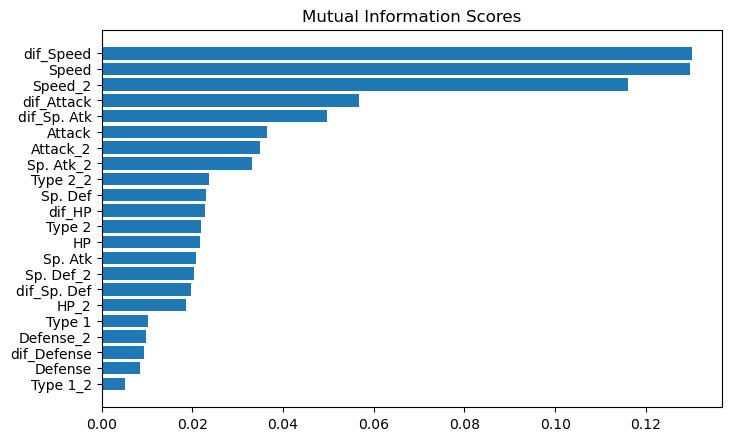

In [32]:
# Visualizzazione su grafico della mutua informazione
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [33]:
# Creo delle copie dei data frame per mantenere inalterati i dati precedenti in modo da 
# poter lavorare sulle features necessarie al modello
prova_train = pk_train.copy()
prova_test = pk_test.copy()

# In base ai valori di MI precedentemente trovati e plottati su grafo possiamo capire 
# che molte features portano poca informazione. Per questo ho scelto di eliminare tutte 
# quelle con valore al di sotto di 0.04 (da Attack_2 in poi)
prova_train = prova_train.drop(['dif_Defense','Defense','Type 1','Defense_2','dif_HP','HP_2','Type 2_2','Type 1_2','dif_Sp. Def','HP','Attack','Attack_2','Type 2','Sp. Atk_2','Sp. Atk','Sp. Def','Sp. Def_2'], axis=1)
prova_test = prova_test.drop(['dif_Defense','Defense','Type 1','Defense_2','dif_HP','HP_2','Type 2_2','Type 1_2','dif_Sp. Def','HP','Attack','Attack_2','Type 2','Sp. Atk_2','Sp. Atk','Sp. Def','Sp. Def_2'], axis=1)

# Queste sono le colonne restanti
prova_train.columns

Index(['Speed', 'Speed_2', 'dif_Attack', 'dif_Sp. Atk', 'dif_Speed',
       'num_winner'],
      dtype='object')

In [34]:
# Separazione delle features dal target
# train
y_train = prova_train.num_winner
prova_train = prova_train.drop(['num_winner'], axis=1)

# test
y_test = prova_test.num_winner
prova_test = prova_test.drop(['num_winner'], axis=1)

### Classificatore

In [35]:
# Separazione dei file di training in training e validation
train_X, val_X, train_y, val_y = train_test_split(prova_train, y_train, random_state = 0)

In [36]:
# Addestramento e calcolo dell'accuracy utilizzando train e validation
classificatore = DecisionTreeClassifier(random_state=0)
classificatore.fit(train_X, train_y)
print("Accuracy on training set: {:.3f}".format(classificatore.score(train_X, train_y)*100))
print("Accuracy on validation set: {:.3f}".format(classificatore.score(val_X, val_y)*100))

Accuracy on training set: 99.942
Accuracy on validation set: 91.463


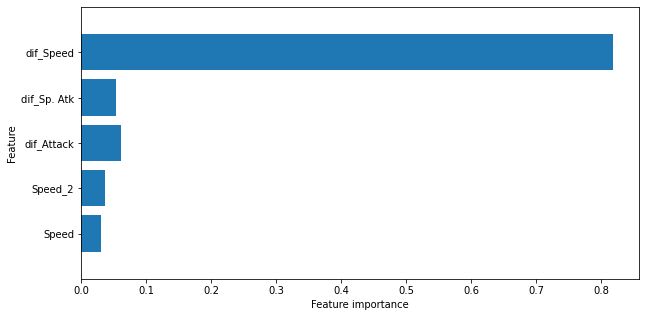

In [37]:
# Stampo un grafo per individuare l'importanza delle feature
def plot_feature_importances_churn(model):
    n_features = train_X.shape[1]
    plt.figure(figsize=(10,5))
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_churn(classificatore)

In [38]:
# Definisco una funzione per individuare l'accuracy del validation set in base ai parametri dati
def max_lif_function(maxD, maxL, X_train, X_val, y_train, y_val):
    model = DecisionTreeClassifier(max_depth=maxD, max_leaf_nodes = maxL, random_state=0)
        # max_leaf_nodes: numero massimo di foglie generabili nell'albero
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    return(accuracy)

In [39]:
# Itero il calcolo dell'accuracy al variare dei parametri e stampo il miglior valore
# i range utilizzati sono stati ottenuti iterando su intervalli sempre più piccoli e con 
# passi decrescenti
m = 0
d = 0
l = 0
for maxD in range(2,11,1):
    for maxL in range(40,60,1):
        my_accuracy = max_lif_function(maxD, maxL, train_X, val_X, train_y, val_y)*10000
        if my_accuracy > m:
            m = my_accuracy
            d = maxD
            l = maxL
print("Max_depth: %d, max_leaf_nodes: %d  \t\t Accuracy:  %d" %(d, l, m))

Max_depth: 7, max_leaf_nodes: 53  		 Accuracy:  9515


In [40]:
# max_leaf_nodes = 53

In [41]:
# max_depth = 7

In [42]:
# Ripeto l'addestramento utilizzando i parametri ottenuti
# Addestramento e calcolo dell'accuracy utilizzando train e validation
from sklearn.tree import DecisionTreeClassifier

classificatore = DecisionTreeClassifier(random_state=0,max_leaf_nodes=53, max_depth=7)
classificatore.fit(train_X, train_y)
print("Accuracy on training set: {:.3f}".format(classificatore.score(train_X, train_y)*100))
print("Accuracy on validation set: {:.3f}".format(classificatore.score(val_X, val_y)*100))

Accuracy on training set: 94.954
Accuracy on validation set: 95.150


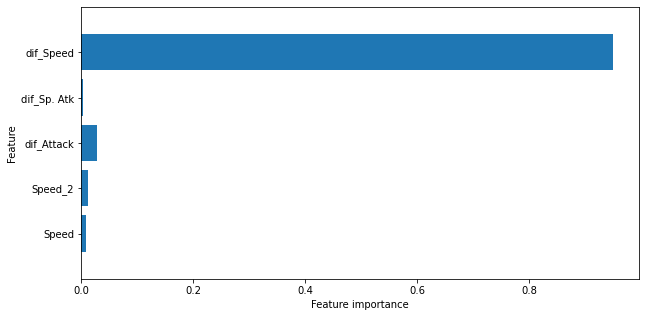

In [43]:
# Visualizzo l'importanza della featurs per questo nuovo modello
plot_feature_importances_churn(classificatore)
# La massimizzazione dell'accuracy incrementa il divario nell'importanza delle feature usate

In [44]:
# Ripeto l'addestramento utilizzando i valori per la consegna
# Addestramento e calcolo dell'accuracy utilizzando train e test
clas = DecisionTreeClassifier(max_depth=7, max_leaf_nodes = 29, random_state=42)

clas.fit(prova_train, y_train)
print("Accuracy on training set: {:.3f}".format(clas.score(prova_train, y_train)*100))
print("Accuracy on test set: {:.3f}".format(clas.score(prova_test, y_test)*100))

Accuracy on training set: 94.881
Accuracy on test set: 94.788
